In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Cargando tablas necesarias...
Datos cargados


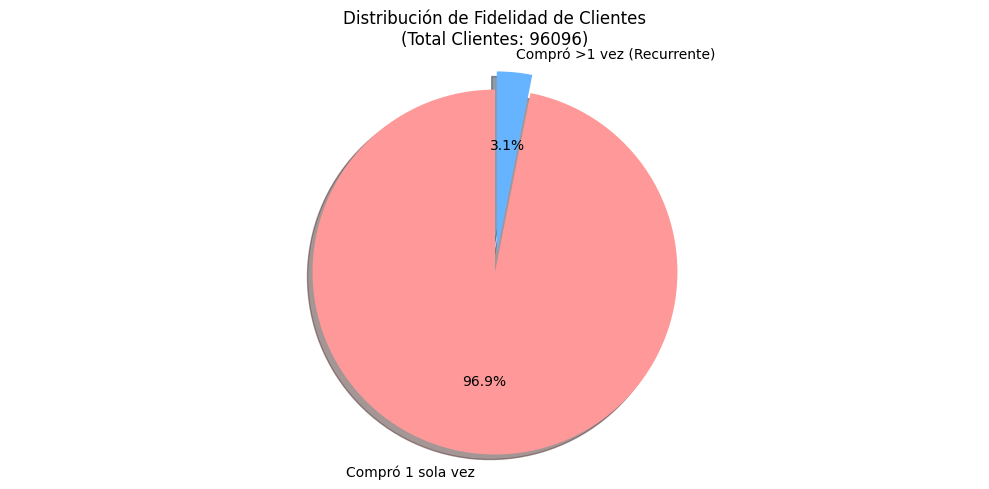

El 96.88% de los usuarios NO tiene historial previo.
CONCLUSIÓN: No podemos usar Filtrado Colaborativo tradicional (User-Based).


/tmp/ipython-input-160841313.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['1 Item (Sin Cross-Sell)', '>1 Items (Carrito Mixto)'],


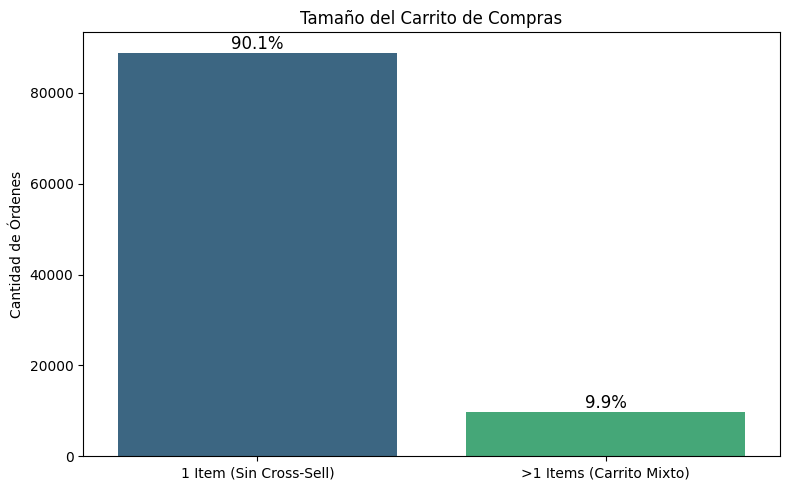

El 90.06% de los pedidos son de un solo producto.
CONCLUSIÓN: El modelo debe enfocarse en 'Productos Similares' (Sustitutos) o 'Cold Start'.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from google.colab import drive

EXTRACT_PATH = '/content/drive/MyDrive/proyecto_modfinal/data_olist/'

# 2. CARGA DE DATOS
print("Cargando tablas necesarias...")
orders = pd.read_csv(os.path.join(EXTRACT_PATH, 'olist_orders_dataset.csv'))
items = pd.read_csv(os.path.join(EXTRACT_PATH, 'olist_order_items_dataset.csv'))
customers = pd.read_csv(os.path.join(EXTRACT_PATH, 'olist_customers_dataset.csv'))

# Fusionar para tener el ID único del cliente
orders_enriched = orders.merge(customers[['customer_id', 'customer_unique_id']], on='customer_id')

print("Datos cargados")

# Contamos cuántas órdenes ha hecho cada cliente único
orders_per_user = orders_enriched.groupby('customer_unique_id')['order_id'].count()
one_time_buyers = (orders_per_user == 1).sum()
total_users = len(orders_per_user)
pct_one_time = (one_time_buyers / total_users) * 100

# Visualización
plt.figure(figsize=(10, 5))
labels = ['Compró 1 sola vez', 'Compró >1 vez (Recurrente)']
sizes = [one_time_buyers, total_users - one_time_buyers]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title(f'Distribución de Fidelidad de Clientes\n(Total Clientes: {total_users})')
plt.axis('equal')
plt.tight_layout()
plt.show()

print(f"El {pct_one_time:.2f}% de los usuarios NO tiene historial previo.")
print("CONCLUSIÓN: No podemos usar Filtrado Colaborativo tradicional (User-Based).")


# Contamos cuántos items tiene cada orden
items_per_order = items.groupby('order_id')['product_id'].count()
single_item_orders = (items_per_order == 1).sum()
total_orders = len(items_per_order)
pct_single = (single_item_orders / total_orders) * 100

# Visualización
plt.figure(figsize=(8, 5))
sns.barplot(x=['1 Item (Sin Cross-Sell)', '>1 Items (Carrito Mixto)'],
            y=[single_item_orders, total_orders - single_item_orders],
            palette='viridis')
plt.title('Tamaño del Carrito de Compras')
plt.ylabel('Cantidad de Órdenes')
plt.text(0, single_item_orders, f"{pct_single:.1f}%", ha='center', va='bottom', fontsize=12)
plt.text(1, total_orders - single_item_orders, f"{100-pct_single:.1f}%", ha='center', va='bottom', fontsize=12)
plt.tight_layout()
plt.show()

print(f"El {pct_single:.2f}% de los pedidos son de un solo producto.")
print("CONCLUSIÓN: El modelo debe enfocarse en 'Productos Similares' (Sustitutos) o 'Cold Start'.")

In [ ]:
import pandas as pd
import os
from google.colab import drive


EXTRACT_PATH = '/content/drive/MyDrive/proyecto_modfinal/data_olist/'


data_files = [
    'olist_customers_dataset.csv',
    'olist_orders_dataset.csv',
    'olist_order_items_dataset.csv',
    'olist_products_dataset.csv',
    'olist_sellers_dataset.csv',
    'olist_order_reviews_dataset.csv',
    'olist_order_payments_dataset.csv',
    'product_category_name_translation.csv',
    'olist_geolocation_dataset.csv'
]


dfs = {}
print("Cargando datasets...")

try:
    for file in data_files:
        # Creamos una clave corta (ej. 'products', 'orders')
        key_name = file.replace('olist_', '').replace('_dataset.csv', '').replace('.csv', '')

        # Caso especial para la traducción
        if key_name == 'product_category_name_translation':
            key_name = 'product_category_name_translation'

        file_path = os.path.join(EXTRACT_PATH, file)
        dfs[key_name] = pd.read_csv(file_path)
        print(f" {key_name} cargado ({dfs[key_name].shape[0]} filas)")

    print("\nCarga completa.")

except FileNotFoundError:
    print(f"\n ERROR: No se encontró el archivo en: {EXTRACT_PATH}")

Cargando datasets...
 customers cargado (99441 filas)
 orders cargado (99441 filas)
 order_items cargado (112650 filas)
 products cargado (32951 filas)
 sellers cargado (3095 filas)
 order_reviews cargado (99224 filas)
 order_payments cargado (103886 filas)
 product_category_name_translation cargado (71 filas)
 geolocation cargado (1000163 filas)

Carga completa.


In [ ]:
import pandas as pd
import numpy as np

print("--- FEATURES  ---")

class OlistDataPipeline:
    def __init__(self, df_dict):
        self.dfs = df_dict.copy()
        self.master_df = None

    def run(self, cutoff_date='2018-05-01'):
        print(f"Ejecutando pipeline con corte al: {cutoff_date}")
        self._create_base()
        self._physical_features()
        self._sales_features(cutoff_date)
        self._sentiment_features(cutoff_date)
        self._one_hot_encoding()
        self._finalize()
        return self.master_df

    def _create_base(self):
        # 1. Base de Productos y Corrección de Typos
        df = self.dfs['products'].copy()
        rename = {
            'product_description_lenght': 'product_description_length',
            'product_name_lenght': 'product_name_length'
        }
        df.rename(columns=rename, inplace=True)

        # Pegar categorías en inglés
        trans = self.dfs['product_category_name_translation']
        df = df.merge(trans, on='product_category_name', how='left')
        df['product_category_name_english'] = df['product_category_name_english'].fillna('unknown')
        self.master_df = df

    def _physical_features(self):
        # 2. Features Físicas (Logística)
        df = self.master_df
        cols = ['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g']
        df[cols] = df[cols].fillna(0)

        # Volumen y Densidad (para entender el tipo de producto)
        df['product_volume_cm3'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
        # Evitar división por cero
        df['product_density_g_cm3'] = df['product_weight_g'] / df['product_volume_cm3'].replace(0, np.nan)
        # Factor de forma (¿Es alargado o cuadrado?)
        df['product_shape_factor'] = df['product_length_cm'] / df['product_width_cm'].replace(0, np.nan)

        df.fillna(0, inplace=True)
        self.master_df = df

    def _sales_features(self, cutoff):
        # 3. Features de Ventas (Precio y Popularidad)
        #  usamos datos del PASADO (Train)
        orders = self.dfs['orders']
        if not pd.api.types.is_datetime64_any_dtype(orders['order_purchase_timestamp']):
            orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

        valid_orders = orders[orders['order_purchase_timestamp'] < cutoff]['order_id']
        valid_items = self.dfs['order_items'][self.dfs['order_items']['order_id'].isin(valid_orders)]

        stats = valid_items.groupby('product_id').agg({
            'order_id': 'count',      # Popularidad
            'price': ['mean', 'std'], # Nivel de precio y Volatilidad
            'freight_value': 'mean'   # Costo de envío promedio
        })
        stats.columns = ['sales_count', 'avg_price', 'price_volatility', 'avg_freight']
        stats.reset_index(inplace=True)

        self.master_df = self.master_df.merge(stats, on='product_id', how='left')

    def _sentiment_features(self, cutoff):
        # 4. Features de Sentimiento (Calidad Percibida)
        # Cruzamos Reviews -> Orders -> Items
        revs = self.dfs['order_reviews']
        items = self.dfs['order_items']
        orders = self.dfs['orders']

        valid_orders = orders[orders['order_purchase_timestamp'] < cutoff]['order_id']
        enriched = revs.merge(items, on='order_id')
        enriched = enriched[enriched['order_id'].isin(valid_orders)]

        # Proporciones (Más útil que el promedio simple)
        enriched['is_1_star'] = (enriched['review_score'] == 1).astype(int)
        enriched['is_5_star'] = (enriched['review_score'] == 5).astype(int)

        stats = enriched.groupby('product_id').agg({
            'review_score': 'mean',
            'review_id': 'count',
            'is_1_star': 'mean',
            'is_5_star': 'mean'
        })
        stats.columns = ['avg_review_score', 'review_count', 'prop_1_star_neg', 'prop_5_star_pos']

        self.master_df = self.master_df.merge(stats, on='product_id', how='left')

    def _one_hot_encoding(self):
        # 5. Categorías a Columnas (Matemática)
        # (de 20 a ~90 columnas)
        dummies = pd.get_dummies(self.master_df['product_category_name_english'], prefix='cat')
        self.master_df = pd.concat([self.master_df, dummies], axis=1)

    def _finalize(self):
        # Limpieza Final
        self.master_df.set_index('product_id', inplace=True)
        self.master_df.fillna(0, inplace=True)
        # Borramos columnas de texto que ya no sirven
        drop_cols = ['product_category_name', 'product_category_name_english']
        self.master_df.drop(columns=drop_cols, inplace=True, errors='ignore')

if 'dfs' in locals():
    pipeline = OlistDataPipeline(dfs)
    df_features = pipeline.run(cutoff_date='2018-05-01')

    print(f"Master Table Generada: {df_features.shape}")
    print("   (Filas: Productos, Columnas: Features)")
    print(f"   Ejemplo de columnas: {df_features.columns[:5].tolist()}...")
else:
    print("Error: No se encuentra la variable 'dfs'. ")

--- FEATURES  ---
Ejecutando pipeline con corte al: 2018-05-01
Master Table Generada: (32951, 90)
   (Filas: Productos, Columnas: Features)
   Ejemplo de columnas: ['product_name_length', 'product_description_length', 'product_photos_qty', 'product_weight_g', 'product_length_cm']...


--- INSPECCIÓN DE FEATURES ---
Total de Columnas: 90

--- Muestra de las primeras 15 features (Físicas/Ventas) ---
['product_name_length', 'product_description_length', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'product_volume_cm3', 'product_density_g_cm3', 'product_shape_factor', 'sales_count', 'avg_price', 'price_volatility', 'avg_freight', 'avg_review_score']

--- Muestra de las últimas 10 features (Categorías One-Hot) ---
['cat_signaling_and_security', 'cat_small_appliances', 'cat_small_appliances_home_oven_and_coffee', 'cat_sports_leisure', 'cat_stationery', 'cat_tablets_printing_image', 'cat_telephony', 'cat_toys', 'cat_unknown', 'cat_watches_gifts']

--- Estadísticas de variables clave ---
       product_weight_g     avg_price  prop_1_star_neg  product_density_g_cm3
count      32951.000000  32951.000000     32951.000000           32951.000000
mean        2276.334315    108.514203         0.105809               0.20367

/tmp/ipython-input-1167891814.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='quejas_bins', y='sales_count', data=sample, palette='Reds')


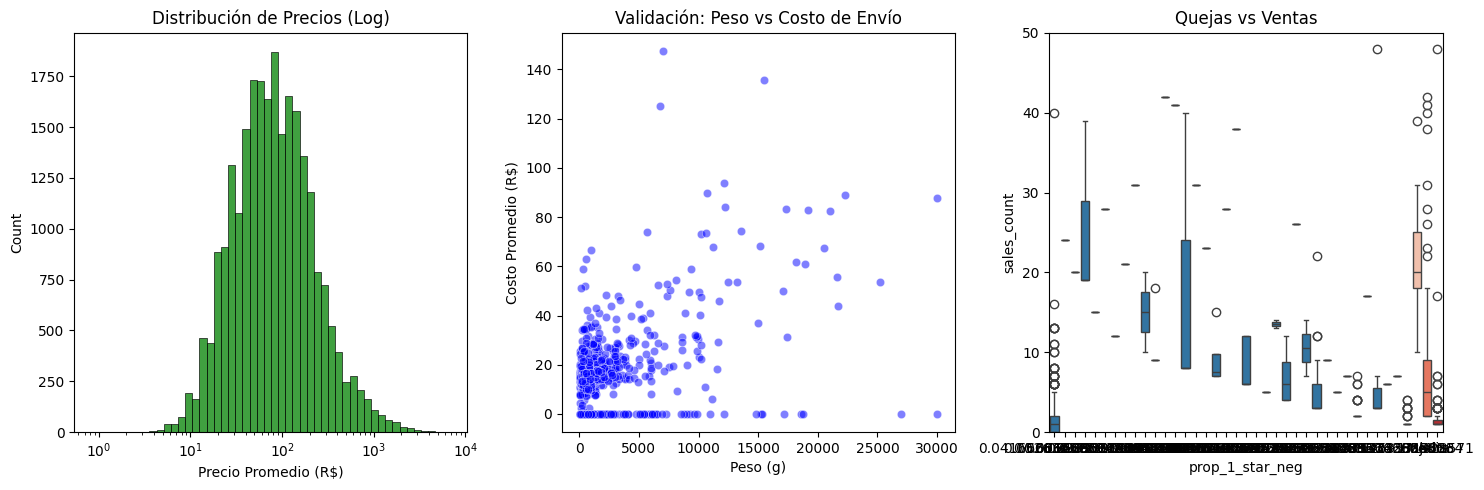

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


print("--- INSPECCIÓN DE FEATURES ---")

# 1. LISTA COLUMNAS
cols = df_features.columns.tolist()
print(f"Total de Columnas: {len(cols)}")
print("\n--- Muestra de las primeras 15 features (Físicas/Ventas) ---")
print(cols[:15])

print("\n--- Muestra de las últimas 10 features (Categorías One-Hot) ---")
print(cols[-10:])

# 2. ESTADÍSTICAS DESCRIPTIVAS (entender magnitudes)

cols_to_check = ['product_weight_g', 'avg_price', 'prop_1_star_neg', 'product_density_g_cm3']
print("\n--- Estadísticas de variables clave ---")
print(df_features[cols_to_check].describe())

# 3. VISUALIZACIÓN: ¿CÓMO SE VEN LAS FEATURES?
plt.figure(figsize=(15, 5))

# Gráfico A: Distribución de Precios (Escala logarítmica)
plt.subplot(1, 3, 1)
sns.histplot(df_features['avg_price'], bins=50, log_scale=True, color='green')
plt.title('Distribución de Precios (Log)')
plt.xlabel('Precio Promedio (R$)')

# Gráfico B: Relación Peso vs Flete
# (Para ver si nuestra feature física tiene sentido con la de ventas)
plt.subplot(1, 3, 2)
# Tomamos una muestra de 1000 puntos para que no sea lento
sample = df_features.sample(1000, random_state=42)
sns.scatterplot(x='product_weight_g', y='avg_freight', data=sample, alpha=0.5, color='blue')
plt.title('Validación: Peso vs Costo de Envío')
plt.xlabel('Peso (g)')
plt.ylabel('Costo Promedio (R$)')

# Gráfico C: Calidad vs Ventas (¿Venden más los productos buenos?)
plt.subplot(1, 3, 3)
sns.boxplot(x='prop_1_star_neg', y='sales_count', data=sample)
# Hacemos bins para la proporción de quejas
sample['quejas_bins'] = pd.cut(sample['prop_1_star_neg'], bins=[0, 0.1, 0.5, 1.0], labels=['Baja', 'Media', 'Alta'])
sns.boxplot(x='quejas_bins', y='sales_count', data=sample, palette='Reds')
plt.title('Quejas vs Ventas')
plt.ylim(0, 50) # Zoom para ver la bmayoría

plt.tight_layout()
plt.show()



--- VISUALIZACIÓN: CALIDAD VS VENTAS ---


/tmp/ipython-input-30061733.py:46: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/tmp/ipython-input-30061733.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bar_data = df_viz.groupby('Nivel_Quejas')['sales_count'].mean().reset_index()
/tmp/ipython-input-30061733.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


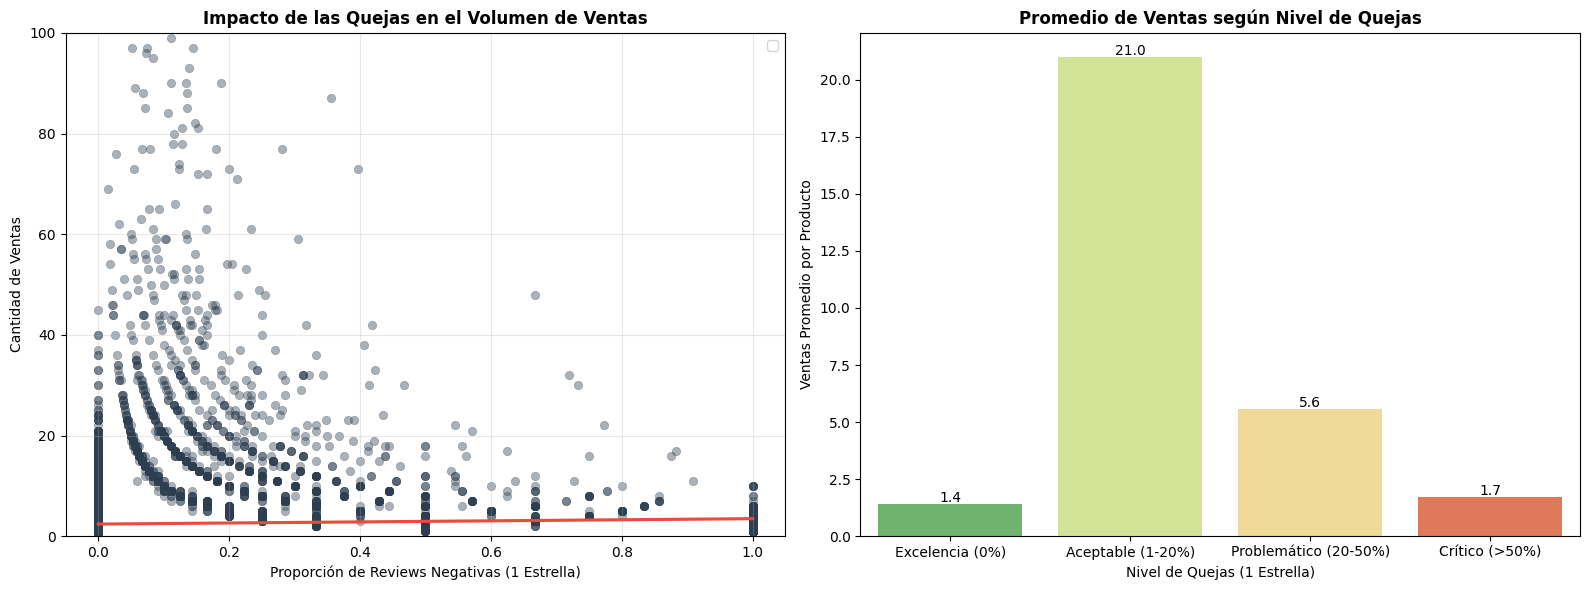

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

print("--- VISUALIZACIÓN: CALIDAD VS VENTAS ---")


df_viz = df_features.copy()

# Creamos categorías legibles para la proporción de quejas (prop_1_star_neg)
# 0.0 = 0% quejas, 1.0 = 100% quejas
bins = [-0.01, 0.01, 0.20, 0.50, 1.0]
labels = ['Excelencia (0%)', 'Aceptable (1-20%)', 'Problemático (20-50%)', 'Crítico (>50%)']
df_viz['Nivel_Quejas'] = pd.cut(df_viz['prop_1_star_neg'], bins=bins, labels=labels)

# 2. CONFIGURACIÓN DE LA FIGURA
plt.figure(figsize=(16, 6))

# --- GRÁFICO A: DISPERSIÓN (SCATTER) ---
plt.subplot(1, 2, 1)
# Usamos escala logarítmica en ventas para ver mejor los datos (porque hay pocos que venden miles)
sns.scatterplot(
    x='prop_1_star_neg',
    y='sales_count',
    data=df_viz,
    alpha=0.4,
    color='#2c3e50',
    edgecolor=None
)
# Añadimos una línea de tendencia suave
sns.regplot(
    x='prop_1_star_neg',
    y='sales_count',
    data=df_viz,
    scatter=False,
    color='#e74c3c',
    line_kws={'label': 'Tendencia'}
)

plt.title('Impacto de las Quejas en el Volumen de Ventas', fontsize=12, fontweight='bold')
plt.xlabel('Proporción de Reviews Negativas (1 Estrella)', fontsize=10)
plt.ylabel('Cantidad de Ventas', fontsize=10)
plt.ylim(0, 100) # Zoom para ignorar los outliers extremos y ver la masa de datos
plt.grid(True, alpha=0.3)
plt.legend()

# --- GRÁFICO B: BARRAS (PROMEDIOS) ---
plt.subplot(1, 2, 2)
# Calculamos el promedio de ventas por grupo
bar_data = df_viz.groupby('Nivel_Quejas')['sales_count'].mean().reset_index()

sns.barplot(
    x='Nivel_Quejas',
    y='sales_count',
    data=bar_data,
    palette='RdYlGn_r' # Verde para bueno, Rojo para malo
)

plt.title('Promedio de Ventas según Nivel de Quejas', fontsize=12, fontweight='bold')
plt.xlabel('Nivel de Quejas (1 Estrella)', fontsize=10)
plt.ylabel('Ventas Promedio por Producto', fontsize=10)

# Añadir etiquetas de valor encima de las barras
for index, row in bar_data.iterrows():
    plt.text(index, row.sales_count + 0.1, f"{row.sales_count:.1f}", color='black', ha="center")

plt.tight_layout()
plt.show()


--- VISUALIZACIÓN 


/tmp/ipython-input-489123428.py:18: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grupo_stats = df_viz.groupby('Grupo_Calidad')['sales_count'].agg(['count', 'sum']).reset_index()
/tmp/ipython-input-489123428.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Grupo', y='Total_Productos_Unicos', data=grupo_stats, ax=axes[0], palette='Blues')
/tmp/ipython-input-489123428.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Grupo', y='Ventas_Totales_Acumuladas', data=grupo_stats, ax=axes[1], palet

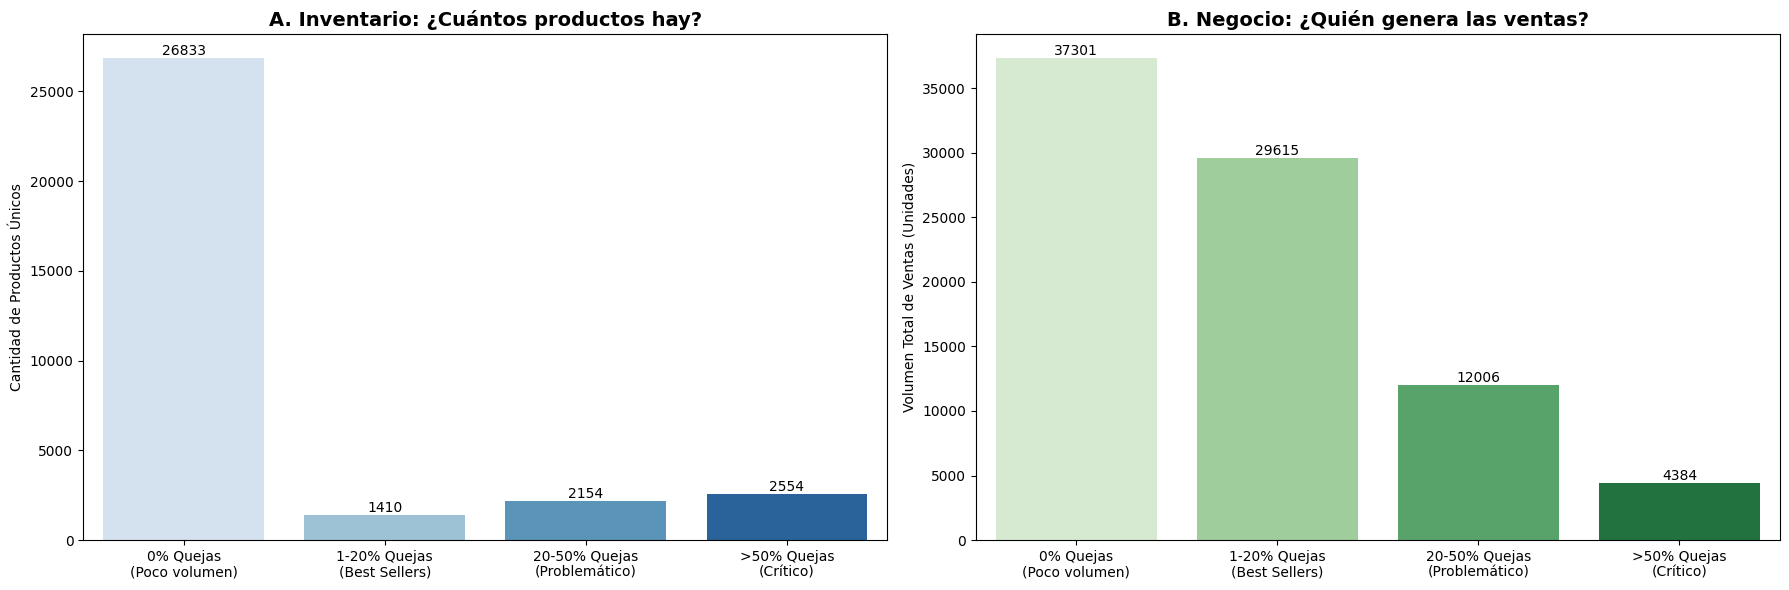

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print("--- VISUALIZACIÓN ")

# 1. PREPARAR DATOS
df_viz = df_features.copy()

bins = [-0.01, 0.01, 0.20, 0.50, 1.0]
labels = ['0% Quejas\n(Poco volumen)', '1-20% Quejas\n(Best Sellers)', '20-50% Quejas\n(Problemático)', '>50% Quejas\n(Crítico)']
df_viz['Grupo_Calidad'] = pd.cut(df_viz['prop_1_star_neg'], bins=bins, labels=labels)

# 2. AGREGAR DATOS

# A. Cuántos productos únicos hay en cada grupo (count)
# B. Cuántas ventas TOTALES generan (sum)
grupo_stats = df_viz.groupby('Grupo_Calidad')['sales_count'].agg(['count', 'sum']).reset_index()
grupo_stats.columns = ['Grupo', 'Total_Productos_Unicos', 'Ventas_Totales_Acumuladas']

# 3. GRAFICAR
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# GRÁFICO A: Cantidad de Productos (El Catálogo)
sns.barplot(x='Grupo', y='Total_Productos_Unicos', data=grupo_stats, ax=axes[0], palette='Blues')
axes[0].set_title('A. Inventario: ¿Cuántos productos hay?', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cantidad de Productos Únicos')
axes[0].set_xlabel('')

# Etiquetas de valor
for index, row in grupo_stats.iterrows():
    axes[0].text(index, row.Total_Productos_Unicos, f"{int(row.Total_Productos_Unicos)}", color='black', ha="center", va='bottom')

# GRÁFICO B: Ventas Totales (El Negocio)
sns.barplot(x='Grupo', y='Ventas_Totales_Acumuladas', data=grupo_stats, ax=axes[1], palette='Greens')
axes[1].set_title('B. Negocio: ¿Quién genera las ventas?', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Volumen Total de Ventas (Unidades)')
axes[1].set_xlabel('')

# Etiquetas de valor
for index, row in grupo_stats.iterrows():
    axes[1].text(index, row.Ventas_Totales_Acumuladas, f"{int(row.Ventas_Totales_Acumuladas)}", color='black', ha="center", va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
df_features.head()

,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_volume_cm3,product_density_g_cm3,product_shape_factor,...,cat_signaling_and_security,cat_small_appliances,cat_small_appliances_home_oven_and_coffee,cat_sports_leisure,cat_stationery,cat_tablets_printing_image,cat_telephony,cat_toys,cat_unknown,cat_watches_gifts
product_id,,,,,,,,,,,,,,,,,,,,,
1e9e8ef04dbcff4541ed26657ea517e5,40.0,287.0,1.0,225.0,16.0,10.0,14.0,2240.0,0.100446,1.142857,...,False,False,False,False,False,False,False,False,False,False
3aa071139cb16b67ca9e5dea641aaa2f,44.0,276.0,1.0,1000.0,30.0,18.0,20.0,10800.0,0.092593,1.500000,...,False,False,False,False,False,False,False,False,False,False
96bd76ec8810374ed1b65e291975717f,46.0,250.0,1.0,154.0,18.0,9.0,15.0,2430.0,0.063374,1.200000,...,False,False,False,True,False,False,False,False,False,False
cef67bcfe19066a932b7673e239eb23d,27.0,261.0,1.0,371.0,26.0,4.0,26.0,2704.0,0.137204,1.000000,...,False,False,False,False,False,False,False,False,False,False
9dc1a7de274444849c219cff195d0b71,37.0,402.0,4.0,625.0,20.0,17.0,13.0,4420.0,0.141403,1.538462,...,False,False,False,False,False,False,False,False,False,False


---SELECCIÓN DE FEATURES (RANDOM FOREST) ---
Entrenando Random Forest con 88 variables...
(Buscando los verdaderos drivers de éxito en Olist...)


/tmp/ipython-input-4071556645.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feat_imp.head(15), palette='viridis')


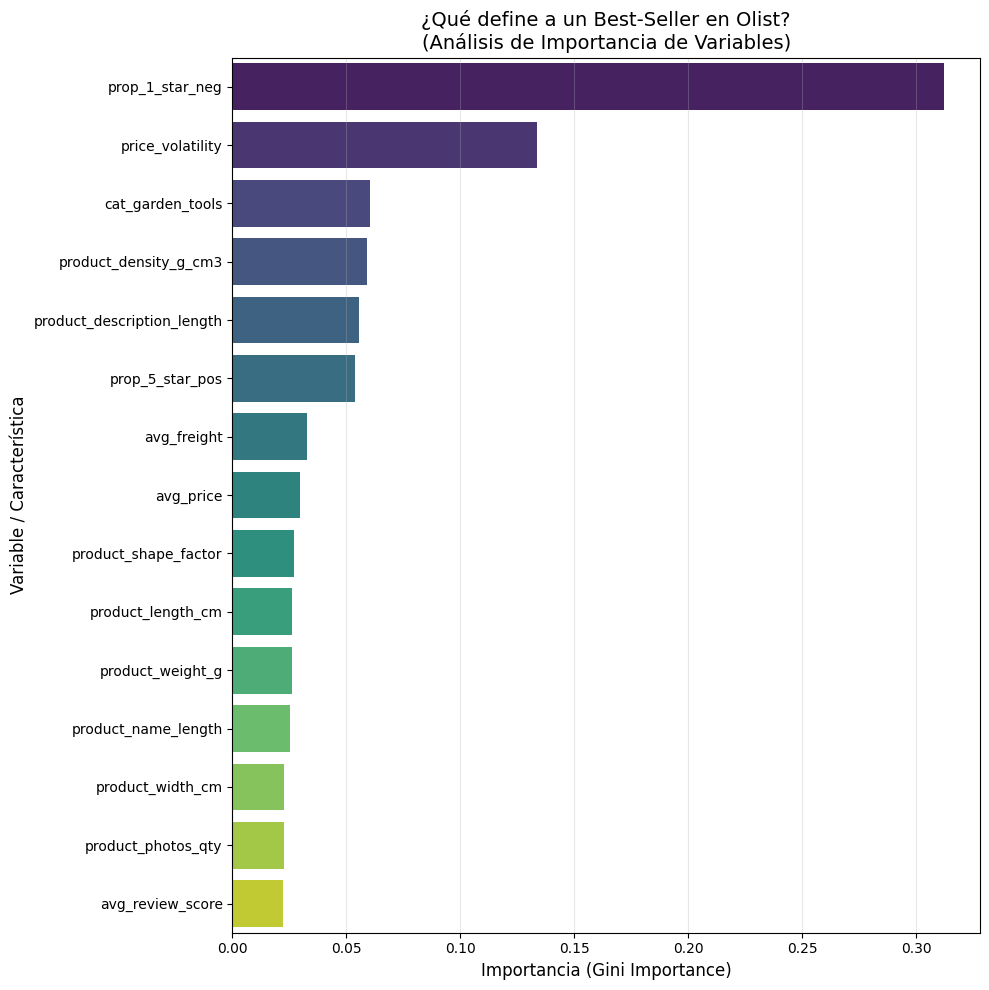


 TOP 10 VARIABLES MÁS IMPORTANTES:
1. prop_1_star_neg (0.3125)
2. price_volatility (0.1335)
3. cat_garden_tools (0.0606)
4. product_density_g_cm3 (0.0592)
5. product_description_length (0.0554)
6. prop_5_star_pos (0.0539)
7. avg_freight (0.0330)
8. avg_price (0.0297)
9. product_shape_factor (0.0269)
10. product_length_cm (0.0263)

 Lista de las 20 mejores features guardada en 'selected_features.pkl'


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import pickle

print("---SELECCIÓN DE FEATURES (RANDOM FOREST) ---")

# 1. PREPARAR DATOS
if 'df_features' not in locals():
    raise ValueError("Falta la tabla 'df_features'. Ejecuta el bloque del Pipeline (Paso 2) primero.")

df_analysis = df_features.copy()

# Variable Objetivo: Queremos entender qué impulsa el 'sales_count' (Ventas)
target = 'sales_count'


cols_to_drop = [
    target,          # Lo que queremos predecir
    'review_count',  # Trampa: Más ventas = más reviews (obvio)
    'num_sellers'    # Trampa: Si vende mucho, llegan más vendedores
]

# X = Variables predictoras
# y = Objetivo (Éxito en ventas)
X = df_analysis.drop(columns=cols_to_drop, errors='ignore')
y = df_analysis[target]

print(f"Entrenando Random Forest con {X.shape[1]} variables...")
print("(Buscando los verdaderos drivers de éxito en Olist...)")

# 3. ENTRENAMIENTO
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X, y)

# 4. EXTRAER RESULTADOS
importances = rf.feature_importances_
feature_names = X.columns

# Crear tabla ordenada
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 5. VISUALIZACIÓN
plt.figure(figsize=(10, 10))
# Mostramos las Top 15
sns.barplot(x='importance', y='feature', data=feat_imp.head(15), palette='viridis')

plt.title('¿Qué define a un Best-Seller en Olist?\n(Análisis de Importancia de Variables)', fontsize=14)
plt.xlabel('Importancia (Gini Importance)', fontsize=12)
plt.ylabel('Variable / Característica', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# 6. REPORTE Y GUARDADO
print("\n TOP 10 VARIABLES MÁS IMPORTANTES:")
top_features = feat_imp.head(20)['feature'].tolist() # Guardamos Top 20 para el modelo

for i, (f, score) in enumerate(zip(top_features[:10], feat_imp.head(10)['importance'])):
    print(f"{i+1}. {f} ({score:.4f})")

# Guardamos la lista de ganadoras para el siguiente paso (Sprint 3)
with open('selected_features.pkl', 'wb') as f:
    pickle.dump(top_features, f)
print("\n Lista de las 20 mejores features guardada en 'selected_features.pkl'")

In [ ]:
import pandas as pd
import numpy as np
import pickle

print("--- GUARDANDO  MASTER TABLE ")


class OlistDataPipeline:
    def __init__(self, df_dict):
        self.dfs = df_dict.copy()
        self.master_df = None

    def run(self, cutoff_date='2018-05-01'):
        print(f"   Procesando datos históricos hasta: {cutoff_date}...")
        self._create_base()
        self._physical_features()
        self._sales_features(cutoff_date)
        self._sentiment_features(cutoff_date)
        self._one_hot_encoding()
        self._finalize()
        return self.master_df

    def _create_base(self):
        df = self.dfs['products'].copy()
        # Corregir typos
        df.rename(columns={'product_description_lenght': 'product_description_length',
                           'product_name_lenght': 'product_name_length'}, inplace=True)
        # Traducciones
        trans = self.dfs['product_category_name_translation']
        df = df.merge(trans, on='product_category_name', how='left')
        df['product_category_name_english'] = df['product_category_name_english'].fillna('unknown')
        self.master_df = df

    def _physical_features(self):
        df = self.master_df
        cols = ['product_length_cm', 'product_height_cm', 'product_width_cm', 'product_weight_g']
        df[cols] = df[cols].fillna(0)
        # Datos físicos
        df['product_volume_cm3'] = df['product_length_cm'] * df['product_height_cm'] * df['product_width_cm']
        df['product_density_g_cm3'] = df['product_weight_g'] / df['product_volume_cm3'].replace(0, np.nan)
        df['product_shape_factor'] = df['product_length_cm'] / df['product_width_cm'].replace(0, np.nan)
        df.fillna(0, inplace=True)
        self.master_df = df

    def _sales_features(self, cutoff):
        # Filtro temporal
        orders = self.dfs['orders']
        if not pd.api.types.is_datetime64_any_dtype(orders['order_purchase_timestamp']):
            orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

        valid_orders = orders[orders['order_purchase_timestamp'] < cutoff]['order_id']
        valid_items = self.dfs['order_items'][self.dfs['order_items']['order_id'].isin(valid_orders)]

        # Estadísticas de ventas
        stats = valid_items.groupby('product_id').agg({
            'order_id': 'count',
            'price': ['mean', 'std'],
            'freight_value': 'mean'
        })
        stats.columns = ['sales_count', 'avg_price', 'price_volatility', 'avg_freight']
        self.master_df = self.master_df.merge(stats, on='product_id', how='left')

    def _sentiment_features(self, cutoff):
        revs = self.dfs['order_reviews']
        items = self.dfs['order_items']
        orders = self.dfs['orders']
        valid_orders = orders[orders['order_purchase_timestamp'] < cutoff]['order_id']

        enriched = revs.merge(items, on='order_id')
        enriched = enriched[enriched['order_id'].isin(valid_orders)]

        enriched['is_1_star'] = (enriched['review_score'] == 1).astype(int)
        enriched['is_5_star'] = (enriched['review_score'] == 5).astype(int)

        stats = enriched.groupby('product_id').agg({
            'review_score': 'mean',
            'review_id': 'count',
            'is_1_star': 'mean',
            'is_5_star': 'mean'
        })
        stats.columns = ['avg_review_score', 'review_count', 'prop_1_star_neg', 'prop_5_star_pos']
        self.master_df = self.master_df.merge(stats, on='product_id', how='left')

    def _one_hot_encoding(self):
        dummies = pd.get_dummies(self.master_df['product_category_name_english'], prefix='cat')
        self.master_df = pd.concat([self.master_df, dummies], axis=1)

    def _finalize(self):
        self.master_df.set_index('product_id', inplace=True)
        self.master_df.fillna(0, inplace=True)
        self.master_df.drop(columns=['product_category_name', 'product_category_name_english'], inplace=True, errors='ignore')

#  GUARDAR
if 'dfs' in locals():
    pipeline = OlistDataPipeline(dfs)
    df_features = pipeline.run(cutoff_date='2018-05-01')

    output_file = 'product_master_features.pkl'
    df_features.to_pickle(output_file)

    print(f"\n Archivo guardado: '{output_file}'")
    print(f"   Dimensiones: {df_features.shape}")
    print("   Ahora sí puedes proceder al Sprint 3.")
else:
    print("Error: Carga primero los datos ('dfs') en el Bloque 1.")

--- GUARDANDO  MASTER TABLE 
   Procesando datos históricos hasta: 2018-05-01...

 Archivo guardado: 'product_master_features.pkl'
   Dimensiones: (32951, 90)
   Ahora sí puedes proceder al Sprint 3.


In [ ]:
import pandas as pd

print("--- INSPECCIÓN MASTER TABLE ")

try:
    master_table = pd.read_pickle('product_master_features.pkl')

    #  dimensiones
    print(f"Archivo encontrado: 'product_master_features.pkl'")
    print(f"Dimensiones: {master_table.shape} (Productos x Features)")

    # muestra de las columnas
    print("\nEjemplo de 5 filas y algunas columnas clave:")
    cols_to_show = ['avg_price', 'product_weight_g', 'prop_1_star_neg', 'sales_count']
    print(master_table[cols_to_show].head())



except FileNotFoundError:
    print(" ALERTA: No se encuentra el archivo 'product_master_features.pkl'.")

--- INSPECCIÓN MASTER TABLE 
Archivo encontrado: 'product_master_features.pkl'
Dimensiones: (32951, 90) (Productos x Features)

Ejemplo de 5 filas y algunas columnas clave:
                                  avg_price  product_weight_g  \
product_id                                                      
1e9e8ef04dbcff4541ed26657ea517e5      10.91             225.0   
3aa071139cb16b67ca9e5dea641aaa2f     248.00            1000.0   
96bd76ec8810374ed1b65e291975717f       0.00             154.0   
cef67bcfe19066a932b7673e239eb23d       0.00             371.0   
9dc1a7de274444849c219cff195d0b71      37.90             625.0   

                                  prop_1_star_neg  sales_count  
product_id                                                      
1e9e8ef04dbcff4541ed26657ea517e5              0.0          1.0  
3aa071139cb16b67ca9e5dea641aaa2f              0.0          1.0  
96bd76ec8810374ed1b65e291975717f              0.0          0.0  
cef67bcfe19066a932b7673e239eb23d              

In [ ]:
import pandas as pd
import pickle

print("--- GENERANDO MASTER ---")

try:

    df_master = pd.read_pickle('product_master_features.pkl')

    # Top Features (Random Forest)
    with open('selected_features.pkl', 'rb') as f:
        selected_cols = pickle.load(f)


    df_model_input = df_master[selected_cols].copy()

    print(f"Tabla generada exitosamente.")
    print(f"Reducción de ruido: De {df_master.shape[1]} columnas -> Bajamos a {df_model_input.shape[1]} columnas.")
    print(f"Total de Productos: {df_model_input.shape[0]}")


    print(df_model_input.head())

    print("\n--- LISTA VARIABLES---")
    print(selected_cols)

    df_model_input.to_pickle('final_model_input.pkl')
    print("\n💾 Guardado como 'final_model_input.pkl'")

except FileNotFoundError:
    print("Error: Faltan los archivos previos. ")

--- GENERANDO MASTER ---
Tabla generada exitosamente.
Reducción de ruido: De 90 columnas -> Bajamos a 20 columnas.
Total de Productos: 32951
                                  prop_1_star_neg  price_volatility  \
product_id                                                            
1e9e8ef04dbcff4541ed26657ea517e5              0.0               0.0   
3aa071139cb16b67ca9e5dea641aaa2f              0.0               0.0   
96bd76ec8810374ed1b65e291975717f              0.0               0.0   
cef67bcfe19066a932b7673e239eb23d              0.0               0.0   
9dc1a7de274444849c219cff195d0b71              0.0               0.0   

                                  cat_garden_tools  product_density_g_cm3  \
product_id                                                                  
1e9e8ef04dbcff4541ed26657ea517e5             False               0.100446   
3aa071139cb16b67ca9e5dea641aaa2f             False               0.092593   
96bd76ec8810374ed1b65e291975717f             False   

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import MinMaxScaler

print("---PREPARACIÓN DE DATOS ---")

# CARGAR ARTEFACTOS
try:
    df_features = pd.read_pickle('product_master_features.pkl')
    with open('selected_features.pkl', 'rb') as f:
        top_features = pickle.load(f)
    print(f" Datos cargados. Total productos: {len(df_features)}")
except FileNotFoundError:
    print(" Error: Faltan archivos .pkl. Ejecuta los pasos anteriores.")

# 2. PREPARAR FEATURES
# Filtramos solo las columnas útiles y escalamos a 0-1
df_dna = df_features[top_features].fillna(0)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_dna)
# Creamos un DataFrame escalado manteniendo el índice (Product ID)
df_dna_scaled = pd.DataFrame(X_scaled, index=df_dna.index, columns=df_dna.columns)

# 3. DEFINIR SET DE VALIDACIÓN
# Usamos Mayo, Junio y Julio de 2018 para probar los modelos
val_start = '2018-05-01'
val_end = '2018-08-01'

orders = dfs['orders']
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Filtramos las órdenes del periodo de prueba
mask_val = (orders['order_purchase_timestamp'] >= val_start) & (orders['order_purchase_timestamp'] < val_end)
val_order_ids = orders[mask_val]['order_id']
val_items = dfs['order_items'][dfs['order_items']['order_id'].isin(val_order_ids)]

# Solo nos sirven carritos con >1 item
items_count = val_items.groupby('order_id')['product_id'].count()
valid_cases = items_count[items_count > 1].index
val_df = val_items[val_items['order_id'].isin(valid_cases)][['order_id', 'product_id']]

print(f" Periodo de Validación: {val_start} al {val_end}")
print(f" Casos de prueba (Carritos reales): {len(valid_cases)}")

---PREPARACIÓN DE DATOS ---
 Datos cargados. Total productos: 32951
 Periodo de Validación: 2018-05-01 al 2018-08-01
 Casos de prueba (Carritos reales): 1954


In [ ]:
print("--- ENTRENANDO MODELO A (LIFT/ASOCIACIÓN) ---")

# 1. OBTENER DATOS DE ENTRENAMIENTO
# Usamos todo lo anterior a Mayo 2018
train_orders = orders[orders['order_purchase_timestamp'] < '2018-05-01']['order_id']
train_items = dfs['order_items'][dfs['order_items']['order_id'].isin(train_orders)]

# 2. FILTRAR ÓRDENES MULTI-ITEM (Donde hubo venta cruzada)
multi_items = train_items.groupby('order_id').filter(lambda x: len(x) > 1)

# 3. CONSTRUIR PARES Y CONTAR
# Self-join para obtener A -> B
pairs = pd.merge(multi_items[['order_id', 'product_id']], multi_items[['order_id', 'product_id']], on='order_id')
pairs = pairs[pairs['product_id_x'] != pairs['product_id_y']] # Quitar A -> A

# Contar frecuencias
pair_counts = pairs.groupby(['product_id_x', 'product_id_y']).size().reset_index(name='count')

# 4. CALCULAR SCORE (LIFT SIMPLIFICADO)
# Penalizamos los productos que son populares por sí mismos
item_freq = train_items['product_id'].value_counts().to_dict()

pair_counts['freq_A'] = pair_counts['product_id_x'].map(item_freq)
pair_counts['freq_B'] = pair_counts['product_id_y'].map(item_freq)

# Score = (Veces Juntos) / (Veces A * Veces B)
pair_counts['score'] = pair_counts['count'] / (pair_counts['freq_A'] * pair_counts['freq_B'])

# 5. CREAR DICCIONARIO
lift_model = {}
# Ordenamos por score para tener los mejores arriba
sorted_pairs = pair_counts.sort_values(['product_id_x', 'score'], ascending=[True, False])

for idx, row in sorted_pairs.iterrows():
    if row['product_id_x'] not in lift_model:
        lift_model[row['product_id_x']] = []
    # Guardamos
    if len(lift_model[row['product_id_x']]) < 10:
        lift_model[row['product_id_x']].append(row['product_id_y'])

print(f" Modelo Lift entrenado. Reglas encontradas para {len(lift_model)} productos.")

--- ENTRENANDO MODELO A (LIFT/ASOCIACIÓN) ---
 Modelo Lift entrenado. Reglas encontradas para 3650 productos.


In [ ]:
from sklearn.neighbors import NearestNeighbors

print("--- ENTRENANDO MODELO B (KNN CONTENT-BASED) ---")

# Usamos K=50 para tener suficientes candidatos para la siguiente etapa
knn_model = NearestNeighbors(n_neighbors=50, metric='cosine', n_jobs=-1)
knn_model.fit(df_dna_scaled)

print(" Modelo KNN entrenado con las Features Relevantes.")

--- ENTRENANDO MODELO B (KNN CONTENT-BASED) ---
 Modelo KNN entrenado con las Features Relevantes.


In [ ]:
from xgboost import XGBClassifier
import random

print("--- ENTRENANDO MODELO C (XGBOOST RANKER)  --")


pairs_pos = pairs[['product_id_x', 'product_id_y']].copy()
pairs_pos['target'] = 1

# Muestra para no saturar RAM (50k ejemplos máximo)
if len(pairs_pos) > 50000:
    pairs_pos = pairs_pos.sample(50000, random_state=42)

# Generamos pares falsos (Negativos)
all_prods = df_dna.index.tolist()
neg_data = []
# Generamos la misma cantidad de negativos que positivos
for _ in range(len(pairs_pos)):
    neg_data.append({
        'product_id_x': random.choice(all_prods),
        'product_id_y': random.choice(all_prods),
        'target': 0
    })
pairs_neg = pd.DataFrame(neg_data)

df_train_xgb = pd.concat([pairs_pos, pairs_neg], ignore_index=True)

# 2. INGENIERÍA DE FEATURES (DELTAS/DIFERENCIAS)
def get_interaction_features(df_pairs, dna_df):
    # Pegar info de A
    df_A = dna_df.loc[df_pairs['product_id_x']].reset_index(drop=True)
    df_A.columns = [f"A_{c}" for c in df_A.columns]
    # Pegar info de B
    df_B = dna_df.loc[df_pairs['product_id_y']].reset_index(drop=True)
    df_B.columns = [f"B_{c}" for c in df_B.columns]

    # Unir todo
    combined = pd.concat([df_pairs.reset_index(drop=True), df_A, df_B], axis=1)

    # Calcular diferencias absolutas
    feat_cols = []
    base_cols = dna_df.columns
    for col in base_cols:
        # --- CORRECCIÓN: Convertir a float para evitar error con booleanos ---
        col_A = combined[f'A_{col}'].astype(float)
        col_B = combined[f'B_{col}'].astype(float)

        combined[f'diff_{col}'] = abs(col_A - col_B)
        feat_cols.append(f'diff_{col}')

    # Retornamos dataset completo con las columnas de diferencia y el target
    return combined, combined['target']

print("Calculando diferencias entre productos (Ingeniería de Features)...")
# Ahora sí llamamos a la función corregida
X_xgb_full, y_xgb = get_interaction_features(df_train_xgb, df_dna)

# Definimos las columnas finales para entrenar
# Usamos las diferencias (diff_) y las características originales de B (B_)
# (A veces saber las características del destino ayuda)
cols_to_drop = ['product_id_x', 'product_id_y', 'target']
X_train_final = X_xgb_full.drop(columns=cols_to_drop, errors='ignore')

# 3. ENTRENAR
print(f"Entrenando XGBoost con {X_train_final.shape[1]} variables...")
xgb_model = XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, n_jobs=-1)
xgb_model.fit(X_train_final, y_xgb)

# Guardamos la lista de columnas exacta para usarla luego
xgb_cols = X_train_final.columns.tolist()

print("✅ Modelo XGBoost entrenado exitosamente.")

--- ENTRENANDO MODELO C (XGBOOST RANKER)  --
Calculando diferencias entre productos (Ingeniería de Features)...
Entrenando XGBoost con 60 variables...
✅ Modelo XGBoost entrenado exitosamente.


In [ ]:
print("--- COMPARACIÓN FINAL (BACKTEST)  ---")

hits_lift = 0
hits_knn = 0
hits_hybrid = 0 # KNN + XGBoost
total = 0
k = 3

# Tomamos una muestra de 1000 carritos para que corra rápido
sample_cases = val_df['order_id'].unique()[:1000]
val_sample = val_df[val_df['order_id'].isin(sample_cases)]

print(f"Evaluando {len(sample_cases)} carritos...")

for order_id, basket in val_sample.groupby('order_id'):
    prods = basket['product_id'].unique().tolist()
    if len(prods) < 2: continue

    for i in range(len(prods)):
        target = prods[i]       # Lo que el usuario realmente compró
        input_p = prods[i-1] if i > 0 else prods[i+1] # Lo que usaremos para predecir

        # Solo evaluamos si el producto input existe en nuestra base
        if input_p not in df_dna.index: continue
        total += 1

        # --- 1. MODELO A: LIFT (Reglas de Asociación) ---
        recs_lift = lift_model.get(input_p, [])[:k]
        if target in recs_lift: hits_lift += 1

        # --- 2. MODELO B: KNN (Similitud de Contenido) ---
        # Usamos doble corchete [[input_p]] para mantenerlo como DataFrame y evitar el Warning
        vec = df_dna_scaled.loc[[input_p]]

        # Pedimos 30 candidatos para tener de donde elegir
        dists, inds = knn_model.kneighbors(vec, n_neighbors=31)
        # El primero es él mismo, lo saltamos
        candidates = df_dna.index[inds.flatten()[1:]].tolist()

        # Para el modelo KNN puro, tomamos los primeros K de esta lista
        if target in candidates[:k]: hits_knn += 1

        # --- 3. MODELO C: HÍBRIDO (Re-Ranking con XGBoost) ---
        # Creamos dataframe de pares para evaluar con el XGBoost
        pairs_eval = pd.DataFrame({
            'product_id_x': [input_p]*len(candidates),
            'product_id_y': candidates
        })

        # --- CORRECCIÓN AQUÍ ---
        # Añadimos una columna target falsa para que la función no falle
        pairs_eval['target'] = 0

        # Generamos features (convertimos a float igual que en el entrenamiento)
        X_eval_full, _ = get_interaction_features(pairs_eval, df_dna)
        # Nos aseguramos de tener las mismas columnas en el mismo orden
        X_eval = X_eval_full[xgb_cols]

        # XGBoost predice la probabilidad de que sea un buen match
        probs = xgb_model.predict_proba(X_eval)[:, 1]

        # Ordenamos los candidatos según la probabilidad de XGBoost (de mayor a menor)
        ranked_candidates = [x for _, x in sorted(zip(probs, candidates), reverse=True)]

        # Tomamos el Top K re-ordenado
        if target in ranked_candidates[:k]: hits_hybrid += 1

print("\n" + "="*60)
print(f"RESULTADOS FINALES (Precision@{k})")
print("="*60)
print(f"1. Lift (Asociación Simple):   {(hits_lift/total)*100:.2f}%")
print(f"2. KNN :      {(hits_knn/total)*100:.2f}%")
print(f"3. Two-Stage (KNN + XGBoost):  {(hits_hybrid/total)*100:.2f}%")
print("="*60)

--- COMPARACIÓN FINAL (BACKTEST)  ---
Evaluando 1000 carritos...

RESULTADOS FINALES (Precision@3)
1. Lift (Asociación Simple):   3.56%
2. KNN :      7.74%
3. Two-Stage (KNN + XGBoost):  9.91%


## Seleccion de modelo
nuestra master table ya esta con datos hasta 2018-05, es decir 19 meses

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import KFold

In [ ]:
df_final = pd.read_pickle('final_model_input.pkl')

In [ ]:
df_final=df_final.reset_index()

## Uso del Cálculo de la Similitud entre Productos

In [ ]:
def get_cosine_sim_df(df_input):
  df = df_input.copy()
  # estandarizar variables numericas
  scaler = StandardScaler()
  col_numericas = ['price_volatility', 'product_density_g_cm3', 'product_description_length',
                      'prop_5_star_pos', 'avg_freight', 'avg_price', 'product_shape_factor',
                      'product_length_cm', 'product_weight_g', 'product_name_length',
                      'product_width_cm', 'product_photos_qty', 'avg_review_score',
                      'product_volume_cm3', 'product_height_cm']
  df[col_numericas] = scaler.fit_transform(df[col_numericas])

  # castear variables booleanas a string
  col_boolean = ['cat_garden_tools', 'cat_health_beauty', 'cat_computers_accessories', 'cat_furniture_decor']
  df[col_boolean] = df[col_boolean].astype(int)

  # Uso de cosine_similarity
  features = df[col_numericas + col_boolean]
  cosine_sim = cosine_similarity(features)
  cosine_sim_df = pd.DataFrame(cosine_sim, index=df['product_id'], columns=df['product_id'])
  return cosine_sim_df


In [ ]:
# Función para recomendar productos similares
def recomendar_producto(cosine_sim_df, product_id, top_n=5):

    if product_id not in cosine_sim_df.index:
        return (f"Producto con ID '{product_id}' no encontrado en el DataFrame.")

    # Obtener las similitudes con el producto seleccionado
    sim_scores = cosine_sim_df[product_id].sort_values(ascending=False)
    # Devolver los productos más similares, excluyendo el propio producto
    return sim_scores.iloc[1:top_n+1]


In [ ]:
cosine_sim_df = get_cosine_sim_df(df_final)

In [ ]:
# Recomendar productos similares al producto con ID '9dc1a7de274444849c219cff195d0b71'
recomendaciones = recomendar_producto(cosine_sim_df, '9dc1a7de274444849c219cff195d0b71')
print(recomendaciones)

product_id
d3b6a4e19012dd1e65f587d3be501fc1    0.972201
07acd9ac393e5b30aded00de63d80e14    0.970973
d7d0c5e4a7f509a4c980aae1530e3bc4    0.970412
f6e0a9ce8a6e91c3a0ca2d3005911d20    0.969843
56677610baf20ec5c96361f374b46153    0.966661
Name: 9dc1a7de274444849c219cff195d0b71, dtype: float64


In [ ]:
def evaluar_recomendaciones(df, cosine_sim_df,top_n=5):
    # Usamos el MSE (Error Cuadrático Medio) o precisión.

    total_error = 0
    for product_id in df['product_id']:
        recomendados = recomendar_producto(cosine_sim_df, product_id, top_n)

        # Como no se esta considerando a los usuarios, no podemos calcular la precisión directamente.
        # En este caso, asumiremos que un producto bien recomendado es uno que es similar en características
        # (usando alguna heurística, por ejemplo, productos de la misma categoría).

        recommended_ids = recomendados.index.tolist()
        true_product_category = df[df['product_id'] == product_id]['cat_garden_tools'].values[0]
        recommended_categories = df[df['product_id'].isin(recommended_ids)]['cat_garden_tools'].values

        # Error simple basado en la coincidencia de categorías
        error = np.sum(true_product_category != recommended_categories)
        total_error += error

    # Promediamos el error para obtener una medida de rendimiento
    avg_error = total_error / len(df)
    return avg_error


In [ ]:
evaluar_recomendaciones(df_final, cosine_sim_df,top_n=5)

np.float64(0.07013444205031713)

El error es bastante bajo, lo que sugiere que las recomendaciones tienen una buena coincidencia en términos de categorías

In [ ]:

def grid_search_top_n(df, k=5, top_n_values=[5, 10, 20]):
    """
    Realiza la búsqueda en cuadrícula para encontrar el mejor valor de top_n.
    """
    best_top_n = None
    best_avg_precision = 0
    best_avg_recall = 0
    numerical_columns = ['price_volatility', 'product_density_g_cm3', 'product_description_length',
                          'prop_5_star_pos', 'avg_freight', 'avg_price', 'product_shape_factor',
                          'product_length_cm', 'product_weight_g', 'product_name_length',
                          'product_width_cm', 'product_photos_qty', 'avg_review_score',
                          'product_volume_cm3', 'product_height_cm']
    boolean_columns = ['cat_garden_tools', 'cat_health_beauty', 'cat_computers_accessories', 'cat_furniture_decor']

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Validación cruzada K-Fold para cada valor de top_n
    for top_n in top_n_values:
        avg_precision_list = []
        avg_recall_list = []

        for train_index, test_index in kf.split(df):
            train_df, test_df = df.iloc[train_index], df.iloc[test_index]

            # Calcular similitudes en el conjunto de entrenamiento
            features_train = train_df[numerical_columns + boolean_columns]
            scaler = StandardScaler()
            features_scaled_train = scaler.fit_transform(features_train)
            cosine_sim_train = cosine_similarity(features_scaled_train)
            cosine_sim_train_df = pd.DataFrame(cosine_sim_train, index=train_df['product_id'], columns=train_df['product_id'])

            # Evaluar en el conjunto de prueba
            avg_precision, avg_recall = evaluar_recomendaciones(test_df, cosine_sim_train_df, top_n)

            avg_precision_list.append(avg_precision)
            avg_recall_list.append(avg_recall)

        # Promediar precisión y recall para este top_n
        avg_precision = np.mean(avg_precision_list)
        avg_recall = np.mean(avg_recall_list)

        print(f"top_n = {top_n}: Precision Promedio = {avg_precision}, Recall Promedio = {avg_recall}")

        # Seleccionar el mejor top_n basado en precisión
        if avg_precision > best_avg_precision:  # Puede usar recall también, depende de tu preferencia
            best_avg_precision = avg_precision
            best_avg_recall = avg_recall
            best_top_n = top_n

    return best_top_n, best_avg_precision, best_avg_recall


In [ ]:
grid_search_top_n(df_final, k=5, top_n_values=[5, 10, 20, 50])

## Uso de K-means

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def getXKMeans(df_input):
  df = df_input.copy()
  # estandarizar variables numericas
  scaler = StandardScaler()
  col_numericas = ['price_volatility', 'product_density_g_cm3', 'product_description_length',
                      'prop_5_star_pos', 'avg_freight', 'avg_price', 'product_shape_factor',
                      'product_length_cm', 'product_weight_g', 'product_name_length',
                      'product_width_cm', 'product_photos_qty', 'avg_review_score',
                      'product_volume_cm3', 'product_height_cm']
  df[col_numericas] = scaler.fit_transform(df[col_numericas])

  # castear variables booleanas a string
  col_boolean = ['cat_garden_tools', 'cat_health_beauty', 'cat_computers_accessories', 'cat_furniture_decor']
  df[col_boolean] = df[col_boolean].astype(int)

  # Uso de cosine_similarity
  features = df[col_numericas + col_boolean]
  return features


Calculando inercia para diferentes valores de K...


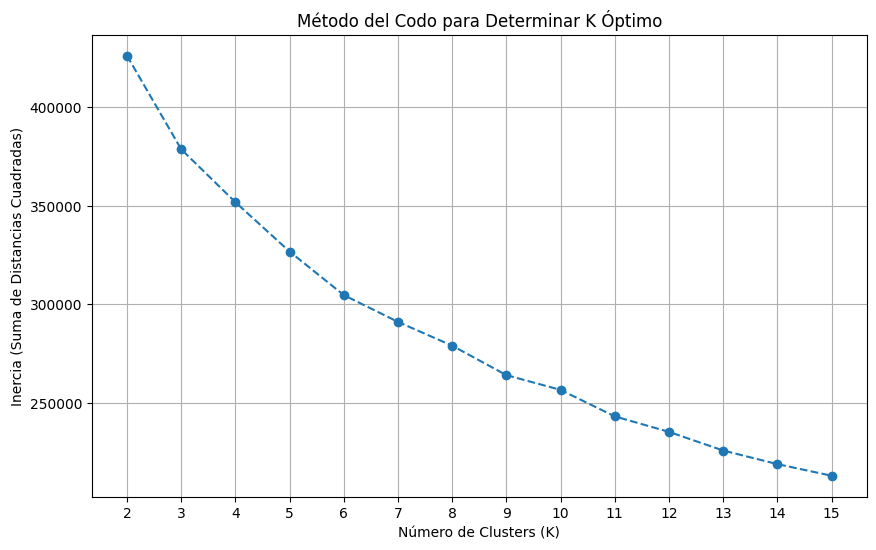

In [ ]:
# Determinar el numero optimo de clusters
K_RANGE = range(2, 16)
inertia = []
X_final = getXKMeans(df_final)
print("Calculando inercia para diferentes valores de K...")
for k in K_RANGE:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_final)
    inertia.append(kmeans.inertia_)

# Visualización del Método del Codo
plt.figure(figsize=(10, 6))
plt.plot(K_RANGE, inertia, marker='o', linestyle='--')
plt.title('Método del Codo para Determinar K Óptimo')
plt.xlabel('Número de Clusters (K)')
plt.ylabel('Inercia (Suma de Distancias Cuadradas)')
plt.xticks(K_RANGE)
plt.grid(True)
plt.show()

In [ ]:
K_OPTIMO = 5
print(f"Aplicando K-Means con K = {K_OPTIMO}...")

# Entrenar el modelo final
kmeans_final = KMeans(n_clusters=K_OPTIMO, random_state=42, n_init=10)
kmeans_final.fit(getXKMeans(df_final))

df_cluster = df_final.copy()
# Asignar la etiqueta de cluster a cada producto en el DataFrame original
df_cluster['Cluster'] = kmeans_final.labels_

# Mostrar la distribución de productos por cluster
print("\nDistribución de Productos por Cluster:")
print(df_cluster['Cluster'].value_counts().sort_index().to_frame('Total de Productos'))

Aplicando K-Means con K = 5...

Distribución de Productos por Cluster:
         Total de Productos
Cluster                    
0                     14371
1                     14255
2                      2938
3                      1376
4                        11


Varianza total explicada por PC1 y PC2: 0.38


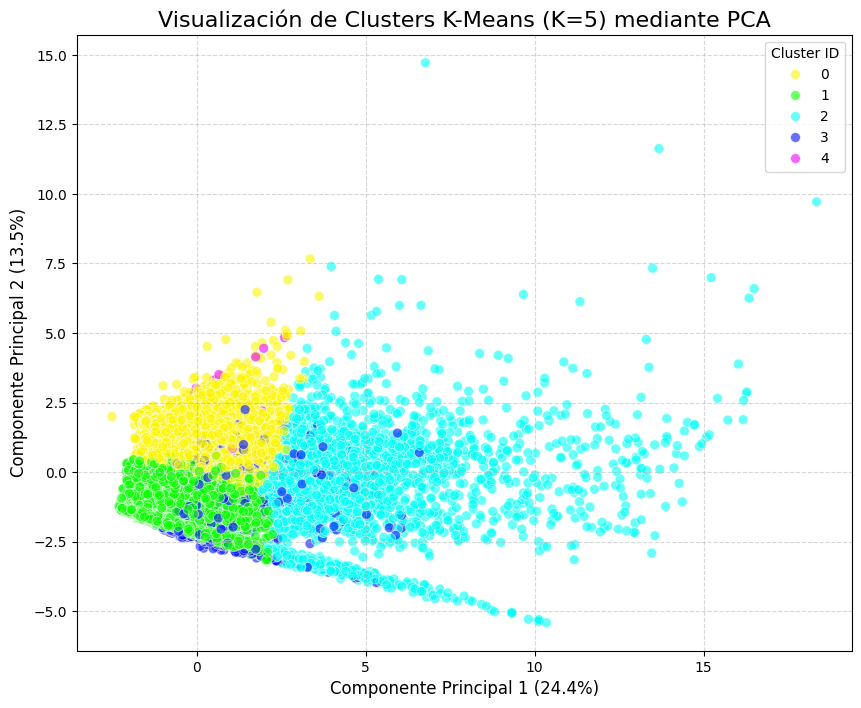

In [ ]:
# Reducimos los datos a 2 componentes principales
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_final)

# Crear un DataFrame con los resultados de PCA y las etiquetas de cluster
pca_df = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])
pca_df['Cluster'] = df_cluster['Cluster'].values

# Mostrar cuánta información capturó el PCA
variance_ratio = pca.explained_variance_ratio_
print(f"Varianza total explicada por PC1 y PC2: {variance_ratio.sum():.2f}")

# --- 2. GENERACIÓN DEL GRÁFICO DE DISPERSIÓN ---

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='Cluster',
    data=pca_df,
    palette=sns.color_palette("hsv", n_colors=K_OPTIMO),
    legend="full",
    alpha=0.6,
    s=50
)

plt.title(f'Visualización de Clusters K-Means (K={K_OPTIMO}) mediante PCA', fontsize=16)
plt.xlabel(f'Componente Principal 1 ({variance_ratio[0]*100:.1f}%)', fontsize=12)
plt.ylabel(f'Componente Principal 2 ({variance_ratio[1]*100:.1f}%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Cluster ID', loc='upper right')
plt.show()

In [ ]:
def recomendar_por_cluster(df_input, product_id_comprado, num_recomendaciones=5):
    df=df_input.copy()
    """Recomienda productos del mismo cluster."""

    # Encontrar el cluster del producto comprado
    try:
        cluster_comprado = df[df['product_id'] == product_id_comprado]['Cluster'].iloc[0]
    except IndexError:
        return "Error: ID de producto no encontrado."

    print(f"\nProducto Ancla: {product_id_comprado} (Cluster {cluster_comprado})")

    # Filtrar todos los productos del mismo cluster, excluyendo el comprado
    productos_similares = df[
        (df['Cluster'] == cluster_comprado) &
        (df['product_id'] != product_id_comprado)
    ]

    # Ranking de los similares: Usamos 'avg_review_score' para el ranking final
    # (Recomendamos los mejores calificados dentro del cluster similar)
    recomendaciones = productos_similares.sort_values(by='avg_review_score', ascending=False).head(num_recomendaciones)

    print(f"Recomendando los {num_recomendaciones} productos mejor rankeados dentro del Cluster {cluster_comprado}:")
    return recomendaciones[['product_id', 'avg_price', 'avg_review_score']]

In [ ]:
# Recomendar productos basado en el producto con ID '9dc1a7de274444849c219cff195d0b71'

print("\n" + "="*50)
print("EJEMPLO DE USO DEL SISTEMA DE RECOMENDACIÓN POR CLUSTERING")
print("="*50)

# Asegúrate de que este ID exista en tu DF
ejemplo_id = '9dc1a7de274444849c219cff195d0b71'
recomendaciones_ejemplo = recomendar_por_cluster(df_cluster,ejemplo_id)
print(recomendaciones_ejemplo.to_markdown(index=False))


EJEMPLO DE USO DEL SISTEMA DE RECOMENDACIÓN POR CLUSTERING

Producto Ancla: 9dc1a7de274444849c219cff195d0b71 (Cluster 0)
Recomendando los 5 productos mejor rankeados dentro del Cluster 0:
| product_id                       |   avg_price |   avg_review_score |
|:---------------------------------|------------:|-------------------:|
| 41d3672d4792049fa1779bb35283ed13 |       45.87 |                  5 |
| 14aa47b7fe5c25522b47b4b29c98dcb9 |       71.99 |                  5 |
| 4508e088c4a07e0ad64f6fa3751e314a |       76.9  |                  5 |
| 1a14237ecc2fe3772b55c8d4e11ccb35 |       14.9  |                  5 |
| bf4538d88321d0fd4412a93c974510e6 |      160    |                  5 |


In [ ]:
# Evaluacion del modelo
K_RANGE = range(2, 11)
silhouette_scores = []

print("\n--- Evaluando el Puntaje de Silueta para diferentes valores de K ---")
for k in K_RANGE:
    # Entrenamos K-Means para cada K
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(getXKMeans(df_final))

    # Calculamos el Silhouette Score
    if k > 1:
        score = silhouette_score(getXKMeans(df_final), cluster_labels)
        silhouette_scores.append(score)
        print(f"K={k}: Puntaje de Silueta = {score:.4f}")



--- Evaluando el Puntaje de Silueta para diferentes valores de K ---
K=2: Puntaje de Silueta = 0.3875
K=3: Puntaje de Silueta = 0.1697
K=4: Puntaje de Silueta = 0.1815
K=5: Puntaje de Silueta = 0.1830
K=6: Puntaje de Silueta = 0.1827
K=7: Puntaje de Silueta = 0.1773
K=8: Puntaje de Silueta = 0.1625
K=9: Puntaje de Silueta = 0.1814
K=10: Puntaje de Silueta = 0.1299


## Uso de DBScan

In [ ]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

Estableciendo min_samples en: 38


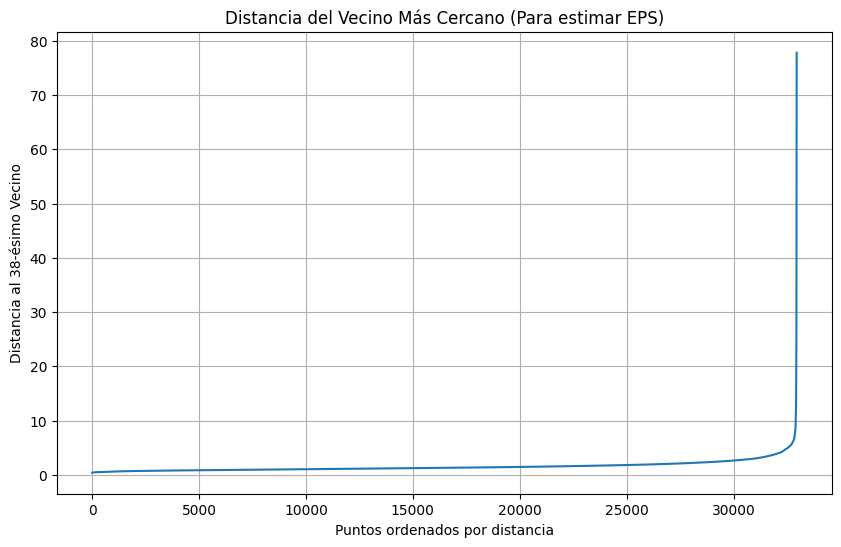

In [ ]:
# Determinar min_samples
MIN_SAMPLES = 2 * getXKMeans(df_final).shape[1]
print(f"Estableciendo min_samples en: {MIN_SAMPLES}")
# Estimar eps usando la distancia k-ésima del vecino más cercano
# Usaremos la distancia al k-ésimo vecino más cercano (donde k = min_samples)
neighbors = NearestNeighbors(n_neighbors=MIN_SAMPLES)
neighbors_fit = neighbors.fit(getXKMeans(df_final))
distances, indices = neighbors_fit.kneighbors(getXKMeans(df_final))

# Ordenar las distancias del k-ésimo vecino
distances = np.sort(distances[:, MIN_SAMPLES-1], axis=0)

# Visualizar el "codo" para estimar EPS (Elbow Method para DBSCAN)
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.title('Distancia del Vecino Más Cercano (Para estimar EPS)')
plt.xlabel('Puntos ordenados por distancia')
plt.ylabel(f'Distancia al {MIN_SAMPLES}-ésimo Vecino')
plt.grid(True)
plt.show()

In [ ]:
EPS_ESTIMADO = 2
N_SAMPLES = 25

df_cluster = df_final.copy()
print(f"\nAplicando DBSCAN con EPS={EPS_ESTIMADO:.4f} y Samples={N_SAMPLES}...")

dbscan = DBSCAN(eps=EPS_ESTIMADO, min_samples=N_SAMPLES)
df_cluster['DBSCAN_Cluster'] = dbscan.fit_predict(getXKMeans(df_final))

# Los clústeres se etiquetan con números positivos (0, 1, 2, etc.)
# El ruido (productos atípicos) se etiqueta como -1.

n_clusters = len(set(df_cluster['DBSCAN_Cluster'])) - (1 if -1 in df_cluster['DBSCAN_Cluster'].unique() else 0)
n_noise = list(df_cluster['DBSCAN_Cluster']).count(-1)

print("\n" + "="*50)
print("RESULTADOS DBSCAN")
print("="*50)
print(f"Número de Clústeres Formados: {n_clusters}")
print(f"Número de Puntos de Ruido (-1): {n_noise}")
print(f"Proporción de Ruido: {n_noise / N_SAMPLES * 100:.2f}%")

print("\nDistribución de Productos por Clúster:")
print(df_cluster['DBSCAN_Cluster'].value_counts().sort_index().to_markdown())

# Si se formaron clústeres, podemos calcular el Puntaje de Silueta:
if n_clusters > 1:
    # Excluimos los puntos de ruido (-1) para el cálculo de Silueta,
    # ya que no pertenecen a ningún clúster.
    X_clusters = X_final[df_cluster['DBSCAN_Cluster'] != -1]
    labels_clusters = df_cluster['DBSCAN_Cluster'][df_cluster['DBSCAN_Cluster'] != -1]

    # Solo calculamos si quedan suficientes puntos y más de un clúster
    if len(labels_clusters.unique()) > 1 and len(X_clusters) > 1:
        silhouette_avg = silhouette_score(X_clusters, labels_clusters)
        print(f"\n Puntaje de Silueta (Excluyendo Ruido): {silhouette_avg:.4f}")
    else:
        print("\nEl puntaje de Silueta no se puede calcular (muy pocos clústeres o puntos).")


Aplicando DBSCAN con EPS=2.0000 y Samples=25...

RESULTADOS DBSCAN
Número de Clústeres Formados: 2
Número de Puntos de Ruido (-1): 2957
Proporción de Ruido: 11828.00%

Distribución de Productos por Clúster:
|   DBSCAN_Cluster |   count |
|-----------------:|--------:|
|               -1 |    2957 |
|                0 |   29952 |
|                1 |      42 |

 Puntaje de Silueta (Excluyendo Ruido): 0.4308


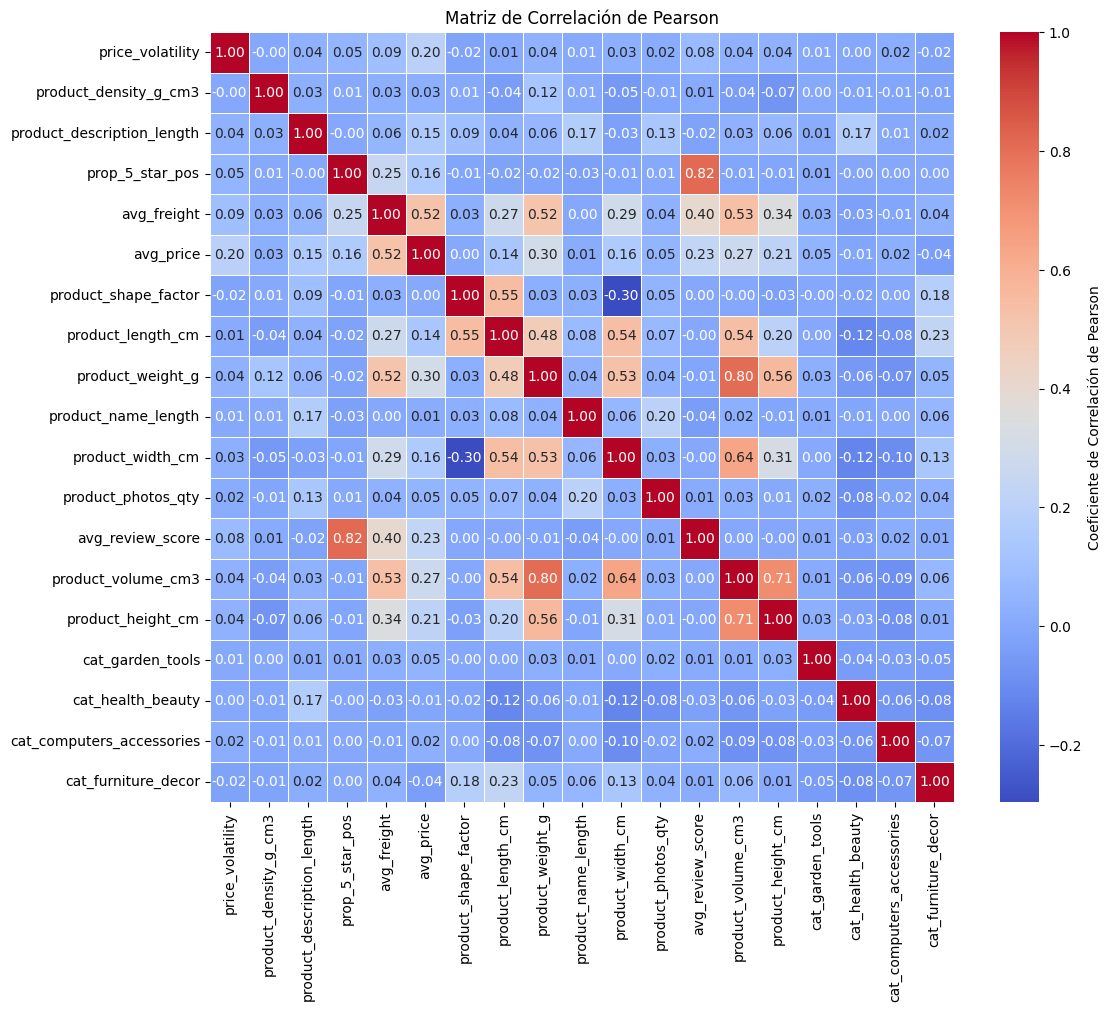

In [ ]:
numeric_df = getXKMeans(df_final).select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_df.corr(method='pearson')

plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    linewidths=.5,
    cbar_kws={'label': 'Coeficiente de Correlación de Pearson'}
)
plt.title('Matriz de Correlación de Pearson')
plt.show()

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  32951 non-null  object 
 1   prop_1_star_neg             32951 non-null  float64
 2   price_volatility            32951 non-null  float64
 3   cat_garden_tools            32951 non-null  bool   
 4   product_density_g_cm3       32951 non-null  float64
 5   product_description_length  32951 non-null  float64
 6   prop_5_star_pos             32951 non-null  float64
 7   avg_freight                 32951 non-null  float64
 8   avg_price                   32951 non-null  float64
 9   product_shape_factor        32951 non-null  float64
 10  product_length_cm           32951 non-null  float64
 11  product_weight_g            32951 non-null  float64
 12  product_name_length         32951 non-null  float64
 13  product_width_cm            329